In [1]:
# Checklist:
# AWS emr-5.29.0
# MASTER r5d.8xlarge 1x, no EBS
# CORE r5d.8xlarge 4x, no EBS
# Custom bootstrap action: s3://ydatazian/bootstrap.sh
# Allow ssh in master node security group

In [2]:
import tqdm.notebook as tqdm
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt

# SparkSession

https://spark.apache.org/docs/2.4.4/api/python/pyspark.html

https://spark.apache.org/docs/2.4.4/api/python/pyspark.sql.html

In [3]:
import findspark
findspark.init()

import spark_utils
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
sc = SparkContext("yarn", "My App", conf=spark_utils.get_spark_conf())
se = SparkSession(sc)
spark_utils.print_ui_links()

NameNode: http://ec2-3-81-103-133.compute-1.amazonaws.com:50070
YARN: http://ec2-3-81-103-133.compute-1.amazonaws.com:8088
Spark UI: http://ec2-3-81-103-133.compute-1.amazonaws.com:20888/proxy/application_1590132351536_0001


# Ephemeral local HDFS

In [4]:
! hdfs dfs -df -h

Filesystem                                  Size     Used  Available  Use%
hdfs://ip-172-31-33-254.ec2.internal:8020  1.6 T  444.5 M      1.6 T    0%


In [5]:
! hdfs dfs -ls /

Found 3 items
drwxrwxrwt   - hdfs hadoop          0 2020-05-22 07:25 /tmp
drwxr-xr-x   - hdfs hadoop          0 2020-05-22 07:25 /user
drwxr-xr-x   - hdfs hadoop          0 2020-05-22 07:25 /var


# Persistent S3

https://www.kaggle.com/c/outbrain-click-prediction/data

In [6]:
! aws s3 ls s3://ydatazian

2020-05-19 13:37:37       1854 bootstrap.sh
2020-05-07 21:18:30  176843889 clicks_test.parquet
2020-05-07 21:18:30  495815517 clicks_train.parquet
2020-05-07 21:18:30   34267065 documents_categories.parquet
2020-05-07 21:18:30  206455957 documents_entities.parquet
2020-05-07 21:18:30   23859965 documents_meta.parquet
2020-05-07 21:18:31  187410196 documents_topics.parquet
2020-05-07 21:18:32  734643471 events.parquet
2020-05-07 21:18:35 50764611872 page_views.parquet
2020-05-07 21:18:35  248421413 page_views_sample.parquet
2020-05-07 21:18:36    5116927 promoted_content.parquet
2020-05-07 21:18:36  273136709 sample_submission.csv
2020-05-21 00:18:24      79688 spanning_tree
2020-05-21 00:17:39    4258712 vw


# Read directly from S3

In [7]:
df = se.read.parquet("s3://ydatazian/page_views.parquet")
df.show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



# Register all tables for sql queries

In [7]:
from IPython.display import display
tables = ["clicks_test", "clicks_train", 
          "documents_categories", "documents_entities", "documents_meta", "documents_topics", 
          "events", "page_views", "page_views_sample", "promoted_content"]
for name in tqdm.tqdm(tables):
    df = se.read.parquet("s3://ydatazian/{}.parquet".format(name))
    df.registerTempTable(name)
    print(name)
    display(df.limit(3).toPandas())

clicks_test


,display_id,ad_id
0,16874594,66758
1,16874594,150083
2,16874594,162754


clicks_train


,display_id,ad_id,clicked
0,1,42337,0
1,1,139684,0
2,1,144739,1


documents_categories


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92


documents_entities


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865314504701
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399113728441297
2,1524246,839907a972930b17b125eb0247898412,0.392095749652966


documents_meta


,document_id,source_id,publisher_id,publish_time
0,1595802,1,603,2016-06-05 00:00:00
1,1524246,1,603,2016-05-26 11:00:00
2,1617787,1,603,2016-05-27 00:00:00


documents_topics


,document_id,topic_id,confidence_level
0,1595802,140,0.0731131601068925
1,1595802,16,0.0594164867373976
2,1595802,143,0.0454207537554526


events


,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505


page_views


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


page_views_sample


,uuid,document_id,timestamp,platform,geo_location,traffic_source
0,1fd5f051fba643,120,31905835,1,RS,2
1,8557aa9004be3b,120,32053104,1,VN>44,2
2,c351b277a358f0,120,54013023,1,KR>12,1


promoted_content


,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7


# Simple SQL query

In [10]:
%%time
df = se.sql(
"""
select 
    uuid, 
    count(1) as cnt
from page_views
group by uuid
""")
df.write.parquet("/count_per_user.parquet", mode='overwrite')

CPU times: user 18.9 ms, sys: 3.06 ms, total: 22 ms
Wall time: 2min 50s


In [11]:
%%time
se.read.parquet("/count_per_user.parquet").show(5)

+--------------+---+
|          uuid|cnt|
+--------------+---+
|8756bd59352317|  1|
|7b20d5c5b9f463|  3|
|cd88da9f6bc54e| 44|
|cb81dd9d5287e8|  9|
|3dc34f9e9eb089| 52|
+--------------+---+
only showing top 5 rows

CPU times: user 2.64 ms, sys: 0 ns, total: 2.64 ms
Wall time: 492 ms


In [12]:
! hdfs dfs -ls /

Found 4 items
drwxr-xr-x   - hadoop hadoop          0 2020-05-22 07:30 /count_per_user.parquet
drwxrwxrwt   - hdfs   hadoop          0 2020-05-22 07:25 /tmp
drwxr-xr-x   - hdfs   hadoop          0 2020-05-22 07:25 /user
drwxr-xr-x   - hdfs   hadoop          0 2020-05-22 07:25 /var


# The same in Python (10x slower)

In [12]:
df = se.table("page_views")
print(df)

DataFrame[uuid: string, document_id: string, timestamp: string, platform: string, geo_location: string, traffic_source: string]


In [13]:
rdd = df.rdd
print(rdd)
print(rdd.take(1))  # sent to driver (our Jupyter kernel)
print(rdd.take(1)[0].uuid)  # Python object

MapPartitionsRDD[41] at javaToPython at NativeMethodAccessorImpl.java:0
[Row(uuid='1fd5f051fba643', document_id='120', timestamp='31905835', platform='1', geo_location='RS', traffic_source='2')]
1fd5f051fba643


In [14]:
%%time
! hdfs dfs -rm -r /count_per_user.pickle
se.table("page_views").rdd\
    .map(lambda x: (x.uuid, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .saveAsPickleFile("/count_per_user.pickle")

rm: `/count_per_user.pickle': No such file or directory
CPU times: user 84.7 ms, sys: 47.4 ms, total: 132 ms
Wall time: 14min 39s


In [15]:
%%time
sc.pickleFile("/count_per_user.pickle").take(5)

CPU times: user 4.58 ms, sys: 0 ns, total: 4.58 ms
Wall time: 273 ms


[('3c58d1e5492dca', 11),
 ('a12ae780183cdb', 30),
 ('1da02cb8987a6b', 3),
 ('69bf3a4dc14efa', 7),
 ('94c581628b3278', 6)]

In [16]:
# and we can convert it back to Spark DataFrame
from pyspark.sql import Row
rdd_of_rows = sc.pickleFile("/count_per_user.pickle")\
    .map(lambda x: Row(uuid=x[0], cnt=x[1]))
df = se.createDataFrame(rdd_of_rows)
df.write.parquet("/count_per_user_converted.parquet", mode='overwrite')

In [17]:
df = se.read.parquet("/count_per_user_converted.parquet")
df.printSchema()
df.show(5)

root
 |-- cnt: long (nullable = true)
 |-- uuid: string (nullable = true)

+---+--------------+
|cnt|          uuid|
+---+--------------+
|  3|ec1e1d69ca180d|
|  5|24727a458b42ec|
|  6|ce86c4017fe64e|
| 11|836c96b4247a66|
|  1|c3476e60057d80|
+---+--------------+
only showing top 5 rows



In [25]:
! hdfs dfs -du -s -h "/*"

10.4 G  /count_per_user.parquet
19.1 G  /count_per_user.pickle
10.4 G  /count_per_user_converted.parquet
0  /tmp
220.5 M  /user
315  /var


# Collect data on the driver

In [26]:
%%time
counts = se.read.parquet("/count_per_user_converted.parquet").rdd\
    .map(lambda x: x.cnt)\
    .collect()

CPU times: user 14.6 s, sys: 2.57 s, total: 17.2 s
Wall time: 1min 27s


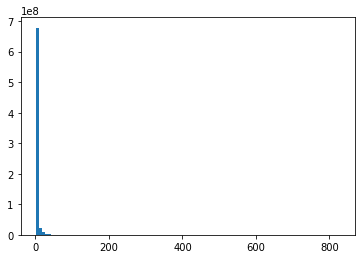

In [27]:
_ = plt.hist(counts, bins=100)

# SQL + Python hybrid

In [4]:
se.table("page_views").show(5)

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
+--------------+-----------+---------+--------+------------+--------------+
only showing top 5 rows



In [5]:
df = se.sql(
"""
select 
    uuid, 
    collect_list(struct(document_id, timestamp, platform, geo_location, traffic_source)) as views
from page_views
group by uuid
""")
df.printSchema()

root
 |-- uuid: string (nullable = true)
 |-- views: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- document_id: string (nullable = true)
 |    |    |-- timestamp: string (nullable = true)
 |    |    |-- platform: string (nullable = true)
 |    |    |-- geo_location: string (nullable = true)
 |    |    |-- traffic_source: string (nullable = true)



In [6]:
%%time
! hdfs dfs -rm -r /platforms_per_user.pickle
from collections import defaultdict

def mapper(x):
    d = defaultdict(int)
    for row in x.views:
        d[row.platform] += 1
    return (x.uuid, d)

df.rdd.map(mapper).saveAsPickleFile("/platforms_per_user.pickle")

Deleted /platforms_per_user.pickle
CPU times: user 40.8 ms, sys: 29.9 ms, total: 70.8 ms
Wall time: 10min 27s


# The same in Python (5x slower)

In [7]:
%%time
! hdfs dfs -rm -r /platforms_per_user2.pickle

def mapper(x):
    d = defaultdict(int)
    for row in x[1]:
        d[row.platform] += 1
    return (x[0], d)

(
    se
    .table("page_views")
    .rdd
    .groupBy(lambda x: x.uuid)
    .map(mapper)
    .saveAsPickleFile("/platforms_per_user2.pickle")
)

rm: `/platforms_per_user2.pickle': No such file or directory
CPU times: user 125 ms, sys: 86.1 ms, total: 211 ms
Wall time: 52min 8s


# Homework 1: Spark EDA

1. Find 10 most visited document_ids in page_views log

In [13]:
# YOUR CODE HERE
se.sql(""" select document_id , count(*) as visits 
       from page_views limit
       group by document_id
       order by visits desc
       limit 10
       """).show()

+-----------+--------+
|document_id|  visits|
+-----------+--------+
|    1179111|26688981|
|     394689|10454691|
|       2191| 5044391|
|       7054| 4996916|
|      38922| 4930261|
|    1154100| 4610780|
|     357569| 4046253|
|    1827718| 3046274|
|        234| 2359994|
|     467462| 2328065|
+-----------+--------+



2. Find 10 most visited topic_ids in page_views log (use documents_topics table)

In [14]:
# YOUR CODE HERE
se.sql(""" select b.topic_id , count(a.document_id) as visits
       from page_views a
       join documents_topics b
       on a.document_id = b.document_id
       group by b.topic_id
       order by visits desc
       limit 10
       """).show()

+--------+---------+
|topic_id|   visits|
+--------+---------+
|      16|226580657|
|     140|175020525|
|      20|171010359|
|     143|153101583|
|     136|137553975|
|     216|109567943|
|       8|105683622|
|     160| 99645579|
|     181| 98421838|
|      97| 90551102|
+--------+---------+



3. Find out how many users have at least two different traffic_sources in their page_views log

In [15]:
# YOUR CODE HERE
se.sql(""" select uuid , count( distinct traffic_source) as source_count
       from page_views
       group by uuid
       having count(distinct traffic_source) > 1
       """).count()

93342305

4. Find out the average uuid (user) CTR (number of clicks in all of her display_ids / (number of impressions ... + 10)). Plot the distribution of individual CTRs as a histogram (bins=100).

In [21]:

# YOUR CODE HERE
ctrAvg = se.sql("""  select v.uuid, views , clicks , 
case when clicks/views is null then 0 else clicks/views end as CTR
from
(select uuid, count(*)+10 as views
from page_views 
group by uuid ) as v
left join
( select uuid, count(*) as clicks 
from events 
group by uuid  ) as c
on c.uuid = v.uuid """ )
##ctrAvg.show(5)

In [22]:

%%time
ctr_counts = ctrAvg.rdd\
    .map(lambda x: x.CTR)\
    .collect()


CPU times: user 29.1 s, sys: 10 s, total: 39.1 s
Wall time: 6min 53s


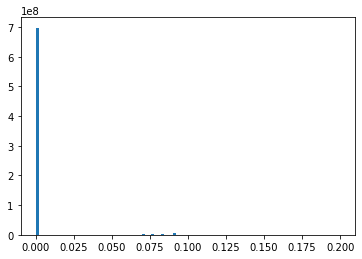

In [25]:
_ = plt.hist(ctr_counts, bins=100, range = [ 0, 0.2 ])

5. Find out how many page views has an average user before encountering a display_id (use timestamp columns). Plot the distribution of individual values.

In [36]:
# YOUR CODE HERE
# YOUR CODE HERE

avg_view_count_before_click = se.sql(""" 
select uuid , min(view_count) as view_count_before_click from ( select v.uuid , v.document_id , v.timestamp, c.display_id , count(v.timestamp) over(partition by v.uuid order by v.timestamp asc)  as view_count
from  ( select * from page_views ) as  v
left join events c
on c.uuid = v.uuid 
and c.document_id = v.document_id 
order by v.uuid, v.timestamp  )
where display_id is not null
group by uuid
""" )
#ctrAvg.show(1000)

In [37]:
avg_view_count_before_click.createOrReplaceTempView("avg_views")

In [39]:
se.sql(" select avg(view_count_before_click) from avg_views").show()

+----------------------------+
|avg(view_count_before_click)|
+----------------------------+
|           4.769817954230487|
+----------------------------+



In [40]:
%%time
avg_views = avg_view_count_before_click.rdd\
    .map(lambda x: x.view_count_before_click)\
    .collect()


CPU times: user 437 ms, sys: 60.6 ms, total: 497 ms
Wall time: 5min 51s


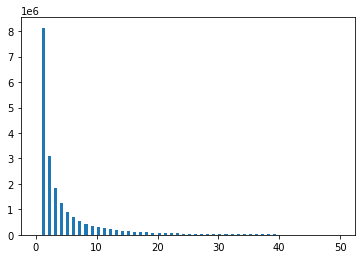

In [41]:
_ = plt.hist(avg_views, bins=100, range = [ 0, 50 ])